### Questions to answer:
1. What do the timing distributions look like?
2. How does AoS compare to SoA?
3. How does tuple size affect timing?
4. How does complexity affect timing?
5. How does access pattern affect timing?

## 1. What do the timing distributions look like? Do we see linearity through container size and number of iterations?

### Getting set up

First, we must load the dataframe. Additionally, we import our dataframe plotting library, aliased here as 'D'.

In [27]:
%matplotlib inline
import pandas as pd
df = pd.read_pickle('unfuck.dataframe')
import df_plot as D
import numpy as np
import matplotlib.pyplot as plt


First, we want to look at a timing distribution. To do this, we define a filter dictionary to constrain our dataframe:

In [28]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 32768,
    'iterations': 32768
}

Before we actually filter the dataset, we can take a look at the type of data which will be returned.

In [29]:
import df_plot as D
import pprint
pp = pprint.PrettyPrinter(indent=2)
unique = D.unique_set(df)
pp.pprint(D.get_selection_type(unique, filter_dict))

Querying with this filter will yield data with these dimensions unspecified:

{ 'benchmarking_tool': array(['chrono_benchmark'], dtype=object),
  'compiler': array(['g++-7.1'], dtype=object),
  'container': array(['vector'], dtype=object),
  'optimization': array(['O3'], dtype=object),
  'run_id': array(['1'], dtype=object),
  'system_memory': array(['64GB'], dtype=object),
  'system_os': array(['Red Hat Enterprise Linux Server 6.9 (Santiago)'], dtype=object),
  'system_processor': array(['Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz'], dtype=object)}


This looks ok. All of the free dimensions have array sizes of 1. This means we should get 1 dimensional timing data querying with this filter dict.

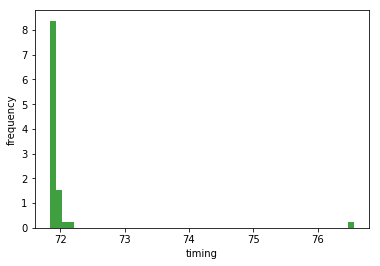

In [4]:
selection = D.filter_df(filter_dict, df)
D.histogram(selection, 'timing')

### Testing for linearity through iterations (single case)

x: [      1      32    1024   32768 1048576]
y: [  9.00243151e-07   2.41962567e-07   5.23910160e-07   3.83405791e-07
   3.46534421e-07]


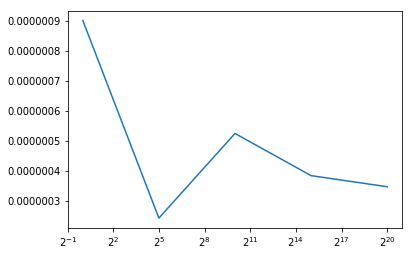

In [5]:
filter_dict = {
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'aos',
    'container_size': 131072
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'iterations', 'timing', sortx=True)
x = np.asarray(x)
y = np.asarray(y) / (x * 1024)

print('x: ' + str(x))
print('y: ' + str(y))

plt.semilogx(x,y,basex=2)

# D.linearity_test(x, y, show_output=True)

This shows how linearity testing will work for each configuration. We'll now go through to verify that every configuration displays the same type of linearity.

### Testing for linearity through iterations (all configurations)

In [6]:
# this takes > an hour
# D.linearity_test_all(unique, df, test_dimension='iterations')

##### What this means...

Because all of these parameter configurations are showing an essentially perfect linear fit, we can proceed with analysis using only the highest iteration data points. These high iteration configurations will have the least noise and we won't lose any information from the lower iteration configurations.

### Testing for linearity through container size (single configuration)

Now that we've established we can look at solely the highest iteration data points, let's take a look at container size and verify we see the same type of linearity there.

TODO: Find the 10 least linear, and plot in both linear and log scale

x: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
y: [0.07234747, 0.14149547, 0.27709749, 0.56644583, 1.1007181, 2.1939662, 4.4165416, 8.7795639, 17.571589, 35.182793, 70.267639, 141.51245, 283.14798, 569.94684, 1183.4451, 2449.3101]
R2 score: 0.99956011
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -5.92746475e+00  -5.85324549e+00  -5.70480696e+00  -5.40792990e+00
  -4.81417577e+00  -3.62666753e+00  -1.25165105e+00   3.49838191e+00
   1.29984478e+01   3.19985797e+01   6.99988434e+01   1.45999371e+02
   2.98000426e+02   6.02002536e+02   1.21000676e+03   2.42601519e+03]


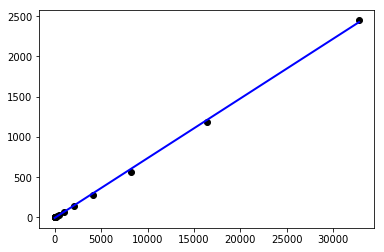

0.99956011129361877

In [7]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'iterations': 1048576
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'container_size', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

### Testing for linearity through container size (all iterations)

In [8]:
# this takes > an hour
# D.linearity_test_all(unique, df, test_dimension='container_size')

##### What this means...

We've now verified that we can do further analysis considering only the highest container size data points. 

## 2. How does AoS compare to SoA?

For this experiment, we'll use iterations per second as a sort of timing normalizer so we can better compare varying parameter configurations.

MAYBE: vary the container size as well in same plot
TODO: X-axis log scale

#### How they're affected by tuple size

{'soa': {'x': [1, 2, 4, 8], 'y': [0.0509586, 0.085127346, 0.065179855, 0.065145604]}, 'aos': {'x': [1, 2, 4, 8], 'y': [0.050709225, 0.074053936, 0.059565369, 0.083438076]}}


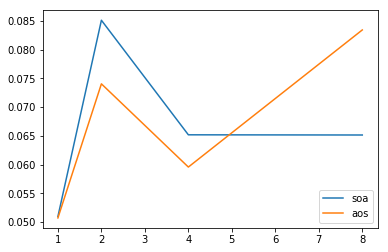

In [9]:
# need this to get the experiment's filter set
must_haves = {
    'container_size': 1024,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
}
let_vary = ['orientation']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['int'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df) 
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)

#### How they're affected by access pattern

TODO: How can we show results for multiple type "bases"

{'aos': {'x': ['combined', 'independent', 'single'], 'y': [10.228698, 7.570085, 7.2594314]}, 'soa': {'x': ['combined', 'independent', 'single'], 'y': [7.7701082, 11.992025, 2.6044223]}}


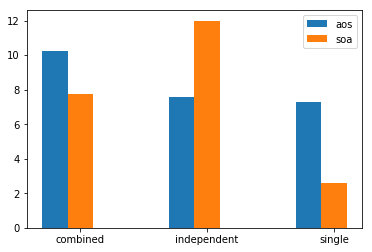

In [10]:
must_haves = {
    'container_size': 1048576,
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 1024,
    'type': 'std::tuple<double, double, double, double>'
}
let_vary = ['orientation', 'access_pattern']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'access_pattern', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

#### More information in single graph

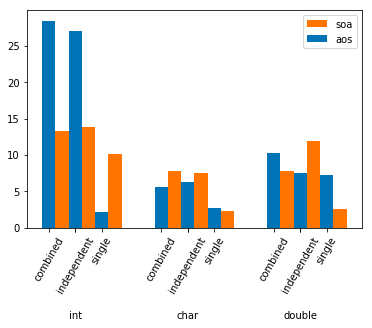

In [11]:
must_haves = {
    'container_size': 1048576,
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 1024,
}
let_vary = ['orientation', 'access_pattern']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['char', 'int', 'double'], [4])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.add_type_bases(selection)
m2_xy = D.m2_xy(selection, 'access_pattern', 'timing', 'orientation', \
                            'type_base', sortx=True)
D.m2_bar(m2_xy, color_ary=['#0074b7', '#ff7500'], label_rotation=60, label_shift=-.35)

#### How they're affected by complexity

{'soa': {'x': ['complex', 'simple'], 'y': [593.12738, 78.19384]}, 'aos': {'x': ['complex', 'simple'], 'y': [602.9082, 222.388]}}


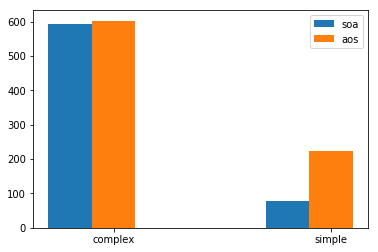

In [12]:
must_haves = {
    'access_pattern': 'single',
    'container_size': 1048576,
    'column': 'nocolumn',
    'iterations': 32768,
    'type': 'std::tuple<double, double, double, double>'
}
let_vary = ['orientation', 'complexity']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'complexity', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

### 3. How does tuple size affect timing?

Here we can see what I think are effects from cache line sizes

{'int': {'x': [1, 2, 4, 8], 'y': [52.765556, 88.750084, 67.265747, 68.709785]}, 'char': {'x': [1, 4], 'y': [49.271606, 75.392082]}, 'double': {'x': [1, 2, 4, 8], 'y': [71.850609, 51.37072, 78.19384, 44.674389]}}


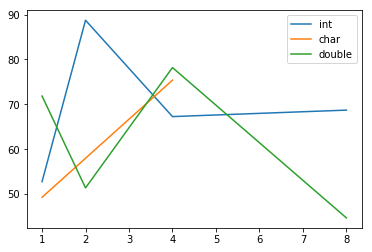

In [13]:
must_haves = {
    'container_size': 1048576,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
    'orientation': 'soa'
}
let_vary = []
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['char', 'int', 'double'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.add_type_bases(selection)
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'type_base', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)

### Results Section 1

      run_id                                       system_os  \
52762      1  Red Hat Enterprise Linux Server 6.9 (Santiago)   
8087       1  Red Hat Enterprise Linux Server 6.9 (Santiago)   
36102      1  Red Hat Enterprise Linux Server 6.9 (Santiago)   
49560      1  Red Hat Enterprise Linux Server 6.9 (Santiago)   
13030      1  Red Hat Enterprise Linux Server 6.9 (Santiago)   

                             system_processor system_memory compiler  \
52762  Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz          64GB  g++-7.1   
8087   Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz          64GB  g++-7.1   
36102  Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz          64GB  g++-7.1   
49560  Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz          64GB  g++-7.1   
13030  Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz          64GB  g++-7.1   

      optimization benchmarking_tool orientation container type  \
52762           O3  chrono_benchmark         soa    vector    1   
8087            O3  chrono_benchmark         soa

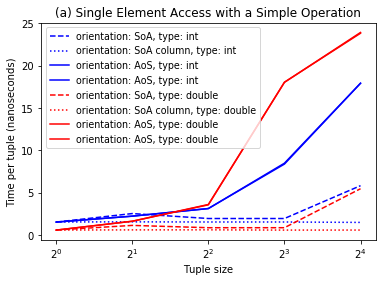

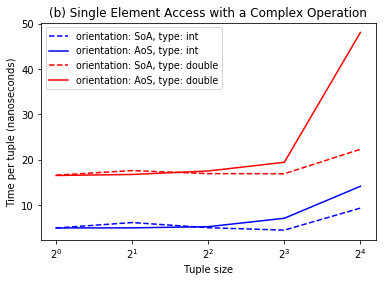

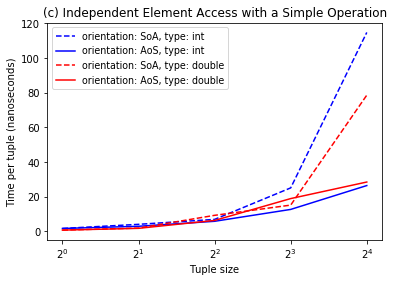

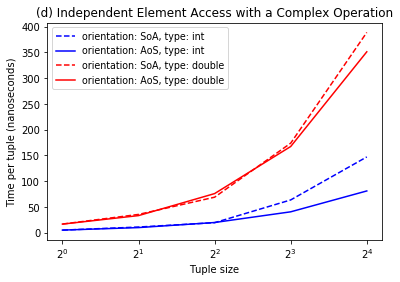

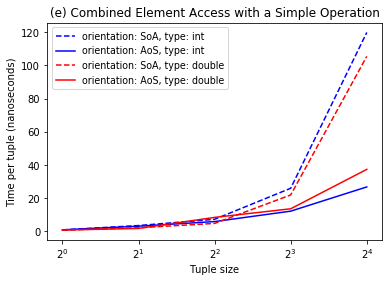

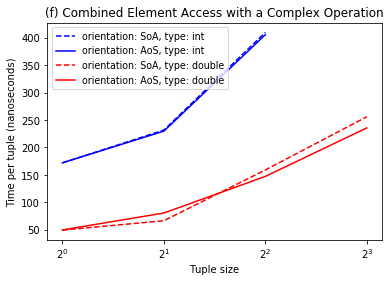

In [32]:
ap = ['single', 'independent', 'combined']
complexity = ['simple', 'complex']
lbls = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
lbl_idx = 0
def to_pretty(o, column):
    if o == 'aos':
        return 'AoS'
    else:
        if column == 'column':
            return 'SoA column'
        else:
            return 'SoA'

for _ap in ap:
    for _cp in complexity:
        must_haves = {
            'container_size': 262144,
            'access_pattern': _ap,
            'complexity': _cp,
            'iterations': 32768
        }
        filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
        allowed_types = D.make_tuple_types(['int', 'double'], [1,2,4,8,16])
        filter_dicts = D.constrain_types(filter_dicts, allowed_types)
        selection = D.multi_filter_df(filter_dicts, df)
        selection = D.add_type_bases(selection)
        selection = D.numeric_types(selection)
        selection['timing'] = selection['timing'].apply(lambda l: np.mean(l))

        d = dict()

        plt.figure()
        legend = list()
        for type in selection['type_base'].unique():
            d[type] = dict()
            for orientation in selection['orientation'].unique():
                for column in selection['column'].unique():
                    if column == 'column' and not (_ap == 'single' and _cp == 'simple'):
                        continue
                    d[type][orientation] = dict()
                    tmp = selection[(selection['orientation'] == orientation) & \
                                    (selection['column'] == column) & (selection['type_base'] == type)].sort_values('type')
                    print(tmp)
                    x = tmp['type'].values
                    y = tmp['timing'].values * 1e9
                    y /= tmp['container_size']
                    y /= tmp['iterations']
                    x = list(x)
                    y = list(y)
                    if type == 'double':
                        line_color = 'r'
                    else:
                        line_color = 'b'
                    if orientation == 'soa':
                        line_style = 'dashed'
                        if column == 'column':
                            line_style = 'dotted'
                    else:
                        line_style = 'solid'
                    plt.plot(x, y, linestyle=line_style, color=line_color)
                    legend.append('orientation: {j}, type: {i}'.format(i=type, j=to_pretty(orientation, column)))
        lbl = lbls[lbl_idx]
        lbl_idx += 1
        plt.title('{lbl} {i} Element Access with a {j} Operation'.format(lbl=lbl, i=_ap.capitalize(),j=_cp.capitalize()))
        plt.xlabel('Tuple size')
        plt.ylabel('Time per tuple (nanoseconds)')
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.legend(legend, loc=0, prop={'size': 9.5}, frameon=True)
        plt.savefig('{i}_{j}.png'.format(i=_cp,j=_ap))

### Results Section 2

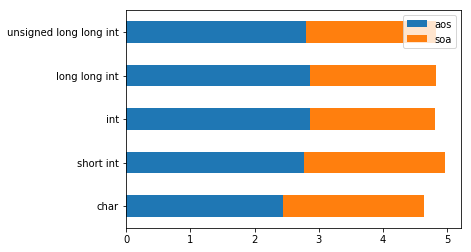

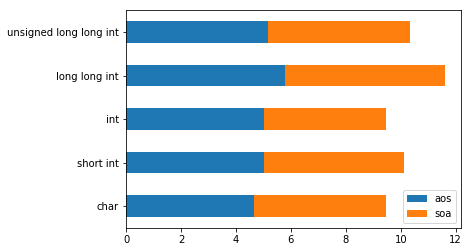

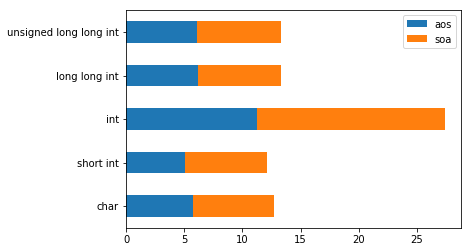

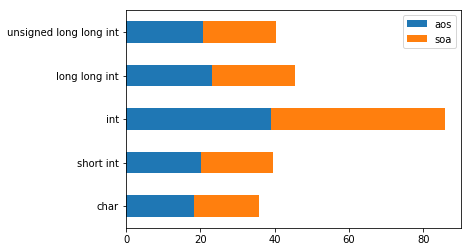

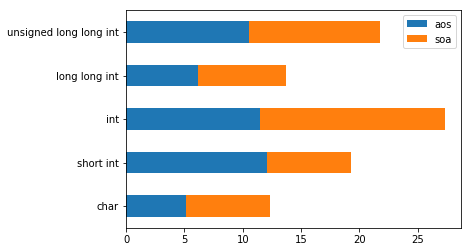

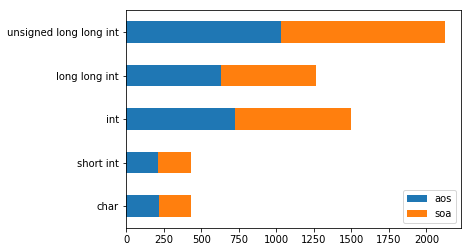

In [16]:
from math import log
ap = ['single', 'independent', 'combined']
complexity = ['simple', 'complex']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
idxs = list()

for _ap in ap:
    df2 = pd.DataFrame(columns=orientations, index=types)
    for _cp in complexity:
        must_haves = {
            'container_size': 65536,
            'access_pattern': _ap,
            'complexity': _cp,
            'column': 'nocolumn',
            'iterations': 32768
        }
        filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
        allowed_types = D.make_tuple_types(types, [4])
        filter_dicts = D.constrain_types(filter_dicts, allowed_types)
        selection = D.multi_filter_df(filter_dicts, df)
        selection = D.add_type_bases(selection)
        selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
        selection['timing'] /= selection['container_size']
        selection['timing'] /= selection['iterations']
        for t in types:
            t_sel = selection[selection['type_base'] == t]
            d = dict()
            for o in orientations:
                d[o] = t_sel[t_sel['orientation'] == o].iloc[0]['timing']
            df2.loc[t] = d
        ax = df2.plot.barh(stacked=True)    

In [30]:
from math import log
ap = ['combined', 'independent', 'single']
complexity = ['complex', 'simple']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
column = ['column', 'nocolumn']

idxs = list()

for _ap in ap:
    for _cp in complexity:
        for o in orientations:
            for _col in column:
                #if _ap == 'combined' and _cp == 'complex':
                #    continue
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                idxs.append(idx_str)

dfs = pd.DataFrame(columns=types, index=idxs)                

for _ap in ap:
    for _cp in complexity:
        for _col in column:
            #if _ap == 'combined' and _cp == 'complex':
            #    continue
            must_haves = {
                'container_size': 65536,
                'access_pattern': _ap,
                'complexity': _cp,
                'column': _col,
                'iterations': 32768
            }
                
            filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
            allowed_types = D.make_tuple_types(types, [4])
            filter_dicts = D.constrain_types(filter_dicts, allowed_types)
            selection = D.multi_filter_df(filter_dicts, df)
            selection = D.add_type_bases(selection)
            selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
            selection['timing'] /= selection['container_size']
            selection['timing'] /= selection['iterations']
            for o in ['aos', 'soa']:
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                o_sel = selection[selection['orientation'] == o]
                d = {'lbl': ''}
                for t in types:
                    d[t] = (o_sel[o_sel['type_base'] == t].iloc[0]['timing'])
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                d['lbl'] = idx_str
                dfs.loc[idx_str] = d

In [31]:
dfs

,char,short int,int,long long int,unsigned long long int
"combined, complex, aos",221.16,213.795,404.36,633.635,1033.33
"combined, complex, soa",209.736,220.544,404.849,631.874,1090.54
"combined, simple, aos",5.17505,12.1181,5.63225,6.12611,10.4963
"combined, simple, soa",7.17869,7.18798,7.17757,7.55209,11.3112
"independent, complex, aos",18.3386,20.1863,19.5159,23.2184,20.581
"independent, complex, soa",17.4153,19.3609,18.9046,22.1148,19.7477
"independent, simple, aos",5.72274,5.08076,5.57896,6.15469,6.07208
"independent, simple, soa",7.00229,6.99845,6.59709,7.1907,7.21247
"single, complex, aos",4.65509,5.01219,4.95797,5.77797,5.15284
"single, complex, soa",4.79808,5.09306,4.9719,5.83056,5.18927


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from math import log
ap = ['combined', 'independent', 'single']
complexity = ['complex', 'simple']
types = ['float', 'double', 'long double']
orientations = ['aos', 'soa']
column = ['column', 'nocolumn']

idxs = list()

for _ap in ap:
    for _cp in complexity:
        for o in orientations:
            for _col in column:
                if _ap == 'combined' and _cp == 'complex':
                    continue
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                idxs.append(idx_str)
#columns = types
#columns.append('lbl')
dfs = pd.DataFrame(columns=columns, index=idxs)                

for _ap in ap:
    for _cp in complexity:
        for _col in column:
            if _ap == 'combined' and _cp == 'complex':
                continue
            must_haves = {
                'container_size': 65536,
                'access_pattern': _ap,
                'complexity': _cp,
                'column': _col,
                'iterations': 32768
            }
                
            filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
            allowed_types = D.make_tuple_types(types, [4])
            filter_dicts = D.constrain_types(filter_dicts, allowed_types)
            selection = D.multi_filter_df(filter_dicts, df)
            selection = D.add_type_bases(selection)
            selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
            selection['timing'] /= selection['container_size']
            selection['timing'] /= selection['iterations']
            for o in ['aos', 'soa']:
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                o_sel = selection[selection['orientation'] == o]
                d = {'lbl': ''}
                for t in types:
                    d[t] = (o_sel[o_sel['type_base'] == t].iloc[0]['timing'])
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                d['lbl'] = idx_str
                dfs.loc[idx_str] = d
dfs

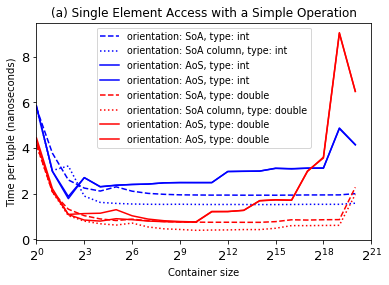

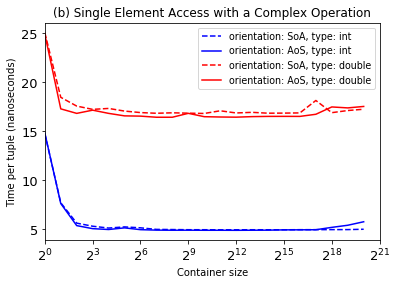

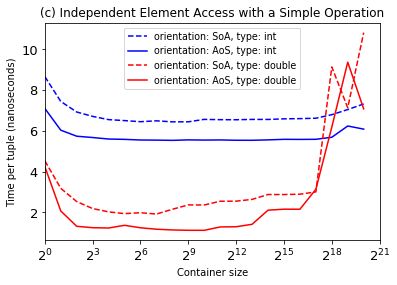

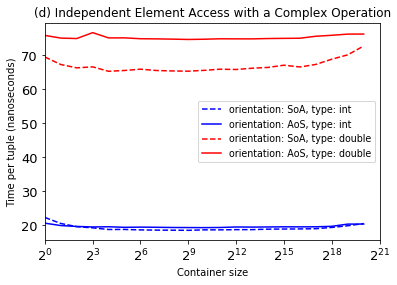

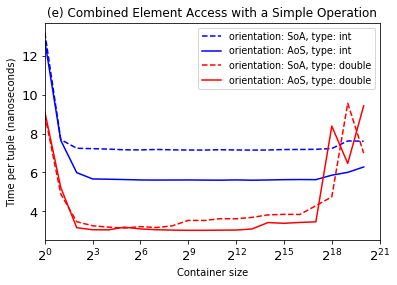

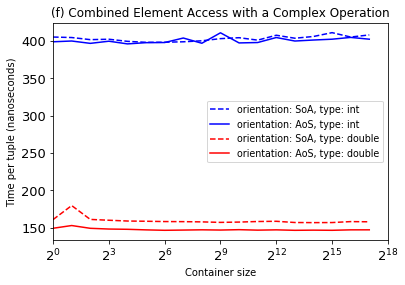

In [33]:
ap = ['single', 'independent', 'combined']
complexity = ['simple', 'complex']
lbls = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
container_sizes = [2**12, 2**13, 2**14, 2**15, 2**16]

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

lbl_idx = 0
def to_pretty(o, column):
    if o == 'aos':
        return 'AoS'
    else:
        if column == 'column':
            return 'SoA column'
        else:
            return 'SoA'

for _ap in ap:
    for _cp in complexity:
        must_haves = {
            'access_pattern': _ap,
            'complexity': _cp,
            'iterations': 32768
        }
        filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
        allowed_types = D.make_tuple_types(['int', 'double'], [4])
        filter_dicts = D.constrain_types(filter_dicts, allowed_types)
        selection = D.multi_filter_df(filter_dicts, df)
        selection = D.add_type_bases(selection)
        selection = D.numeric_types(selection)
        selection['timing'] = selection['timing'].apply(lambda l: np.mean(l))

        d = dict()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        legend = list()
        for type in selection['type_base'].unique():
            d[type] = dict()
            for orientation in selection['orientation'].unique():
                for column in selection['column'].unique():
                    if column == 'column' and not (_ap == 'single' and _cp == 'simple'):
                        continue
                    d[type][orientation] = dict()
                    tmp = selection[(selection['orientation'] == orientation) & \
                                    (selection['column'] == column) & (selection['type_base'] == type)].sort_values('container_size')
                   
                    if _cp == 'complex' and _ap == 'combined':
                        tmp = tmp[tmp['container_size'] <= 2**17]
                    x = tmp['container_size'].values
                    y = tmp['timing'].values * 1e9
                    y /= tmp['container_size']
                    y /= tmp['iterations']
                    x = list(x)
                    y = list(y)
                    if type == 'double':
                        line_color = 'r'
                    else:
                        line_color = 'b'
                    if orientation == 'soa':
                        line_style = 'dashed'
                        if column == 'column':
                            line_style = 'dotted'
                    else:
                        line_style = 'solid'
                    plt.plot(x, y, linestyle=line_style, color=line_color)
                    legend.append('orientation: {j}, type: {i}'.format(i=type, j=to_pretty(orientation, column)))
        lbl = lbls[lbl_idx]
        lbl_idx += 1
        plt.title('{lbl} {i} Element Access with a {j} Operation'.format(lbl=lbl, i=_ap.capitalize(),j=_cp.capitalize()))
        plt.xlabel('Container size')
        plt.ylabel('Time per tuple (nanoseconds)')
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        if not (_cp == 'complex' and _ap == 'combined'):
            plt.xlim([1, 2**21])
        else:
            plt.xlim([1, 2**18])
        plt.legend(legend, loc=0, prop={'size': 9.5}, frameon=True)
        plt.savefig('{i}_{j}_cs.png'.format(i=_cp,j=_ap), bbox_inches='tight')